In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

## 全結合層

In [9]:
class Linear:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        #self.dW = np.dot(self.x[None,:].T, dout[None,:])
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

## sigmoid関数

In [10]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

## Relu関数

In [11]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

## ネットワーク全体のクラス

In [12]:
class MLP_init:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.random.randn(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.random.randn(output_size)
        
        self.layers = OrderedDict()
        self.layers['Linear1'] = Linear(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Linear2'] = Linear(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        if type(t) != np.ndarray or type(t) != list:
            t = np.array(t, dtype = int)
            t = np.eye(2)[t]
        y = self.predict(x)
        return 1/2 * np.sum((y - t) ** 2)
    
    
    def accuracy(self, x, t):
        y = np.argmax(self.predict(x), axis = 1)
        acc = np.sum(y == t)/float(x.shape[0])
        return acc
        
    
    def gradient(self, x, t):
        #backward
        if type(t) != np.ndarray or type(t) != list:
            t = np.array(t, dtype = int)
            t = np.eye(2)[t]
        dout = self.predict(x) - t
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Linear1'].dW
        grads['b1'] = self.layers['Linear1'].db
        grads['W2'] = self.layers['Linear2'].dW
        grads['b2'] = self.layers['Linear2'].db
        
        return grads

## データの環境
@attribute 'age' numeric<br>
@attribute 'bp'  numeric<br>
@attribute 'sg' {1.005,1.010,1.015,1.020,1.025}<br>
@attribute 'al' {0,1,2,3,4,5}<br>
@attribute 'su' {0,1,2,3,4,5}<br>
@attribute 'rbc' {normal,abnormal} -> 0, 1<br>
@attribute 'pc' {normal,abnormal} -> 0, 1<br>
@attribute 'pcc' {present,notpresent} -> 1, 0<br>
@attribute 'ba' {present,notpresent} -> 1, 0<br>
@attribute 'bgr'  numeric<br>
@attribute 'bu' numeric<br>
@attribute 'sc' numeric<br>
@attribute 'sod' numeric<br>
@attribute 'pot' numeric<br>
@attribute 'hemo' numeric<br>
@attribute 'pcv' numeric<br>
@attribute 'wbcc' numeric<br>
@attribute 'rbcc' numeric<br>
@attribute 'htn' {yes,no} -> 1, 0<br>
@attribute 'dm' {yes,no} -> 1, 0<br>
@attribute 'cad' {yes,no} -> 1, 0<br>
@attribute 'appet' {good,poor}  -> 1, 0<br>
@attribute 'pe' {yes,no}  -> 1, 0<br>
@attribute 'ane' {yes,no} -> 1, 0<br>
@attribute 'class' {ckd,notckd} -> 1, 0<br>


## データインポート

### 未入力値は0に設定

In [125]:
file_path = "/Users/isonoyuma/python_workspace/work_later/data_set/chronic_kidney_disease_dataset/chronic_kidney_disease.arff"

data = np.zeros([400, 24])
label = np.zeros(400)

with open(file_path, newline="")as f:
    s = [s.strip() for s in f.readlines()]
    s = [x.split(",") for x in s[29:429]]
for i,x in enumerate(s):
    for j, y in enumerate(x):
        if y == "?":
            s[i][j] = 0
        elif y == "normal":
            s[i][j] = 0
        elif y == "abnormal":
            s[i][j] = 1
        elif y == "present":
            s[i][j] = 1
        elif y == "notpresent":
            s[i][j] = 0
        elif y == "yes":
            s[i][j] = 1
        elif y == "no":
            s[i][j] = 0
        elif y == "good":
            s[i][j] = 1
        elif y == "poor":
            s[i][j] = 0
        elif y == "ckd":
            label[i] = 1
            s[i].pop(j)
        elif y == "notckd":
            label[i] = 0
            s[i].pop(j)
        else:
            s[i][j] = float(s[i][j])
        
        
        
for i, x in enumerate(s):
    data[i,:] = x

    
data = preprocessing.scale(data)

## 未入力値ゼロにしたデータから、平均値か中央値を取り、再度データをインポートし、未入力値を平均値に置き換える。

In [128]:
#mean_list = np.mean(data, axis = 0)#未入力値は平均値とする
median_list = np.median(data, axis = 0)#未入力値は中央値とする
file_path = "/Users/isonoyuma/python_workspace/work_later/data_set/chronic_kidney_disease_dataset/chronic_kidney_disease.arff"

data = np.zeros([400, 24])
label = np.zeros(400)

with open(file_path, newline="")as f:
    s = [s.strip() for s in f.readlines()]
    s = [x.split(",") for x in s[29:429]]
for i,x in enumerate(s):
    for j, y in enumerate(x):
        if y == "?":
            #s[i][j] = mean_list[j]
            s[i][j] = median_list[j]
        elif y == "normal":
            s[i][j] = 0
        elif y == "abnormal":
            s[i][j] = 1
        elif y == "present":
            s[i][j] = 1
        elif y == "notpresent":
            s[i][j] = 0
        elif y == "yes":
            s[i][j] = 1
        elif y == "no":
            s[i][j] = 0
        elif y == "good":
            s[i][j] = 1
        elif y == "poor":
            s[i][j] = 0
        elif y == "ckd":
            label[i] = 1
            s[i].pop(j)
        elif y == "notckd":
            label[i] = 0
            s[i].pop(j)
        else:
            s[i][j] = float(s[i][j])
        
        
        
for i, x in enumerate(s):
    data[i,:] = x

    
data = preprocessing.scale(data)

 11%|█         | 1103/10000 [00:00<00:01, 5478.80it/s]

0.5291666666666667
1.0


 27%|██▋       | 2691/10000 [00:00<00:01, 5320.38it/s]

1.0
1.0


 49%|████▉     | 4938/10000 [00:00<00:00, 5586.16it/s]

1.0
1.0


 66%|██████▌   | 6590/10000 [00:01<00:00, 5541.46it/s]

1.0
1.0


 88%|████████▊ | 8829/10000 [00:01<00:00, 5580.63it/s]

1.0
1.0


100%|██████████| 10000/10000 [00:01<00:00, 5409.34it/s]


0.98125
[[ 30   0]
 [  3 127]]


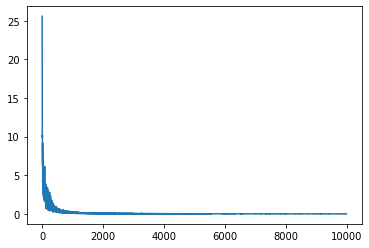

In [129]:
network = MLP_init(input_size=24, hidden_size=10, output_size=2)
#X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.4, stratify = label)
data1 = data[label==1]
data0 = data[label==0]
X_train = np.vstack((data1[:120],data0[:120]))
X_test = np.vstack((data1[120:],data0[120:]))
y_train = [1 for x in range(120)]
y_train.extend([0 for x in range(120)])
y_train = np.array(y_train)
y_test = [1 for x in range(130)]
y_test.extend([0 for x in range(30)])
y_test = np.array(y_test)

num_of_seed = np.random.randint(0, 100)
for l in [X_train, y_train]:
    np.random.seed(num_of_seed)
    np.random.shuffle(l)
num_of_seed = np.random.randint(0, 100)
for l in [X_test, y_test]:
    np.random.seed(num_of_seed)
    np.random.shuffle(l)


iters_num = 10000
learning_rate = 0.02
batch_size = 100
train_size = X_train.shape[0]
train_loss_list = []
train_acc_list = []
test_acc_list = []

for x in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)#変更点
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    grad = network.gradient(X_batch, y_batch)
    for key in ['W1', 'b1', 'W2', 'b2']:
            network.params[key] -= learning_rate * grad[key]
    train_loss_list.append(network.loss(X_batch, y_batch))
    if x % 1000 == 0:
        train_acc = network.accuracy(X_train, y_train)
        train_acc_list.append(train_acc)
        print(train_acc)
plt.plot(train_loss_list)
test_acc = network.accuracy(X_test, y_test)
print(test_acc)
y_pred = np.argmax(network.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

  9%|▉         | 907/10000 [00:00<00:02, 4090.19it/s]

280
0.5964285714285714


 19%|█▊        | 1869/10000 [00:00<00:01, 4427.77it/s]

0.9964285714285714


 29%|██▉       | 2937/10000 [00:00<00:01, 4846.97it/s]

1.0
1.0


 50%|█████     | 5032/10000 [00:01<00:00, 5201.36it/s]

1.0
1.0


 65%|██████▌   | 6549/10000 [00:01<00:00, 4582.54it/s]

1.0


 76%|███████▌  | 7571/10000 [00:01<00:00, 4852.93it/s]

1.0
1.0


100%|██████████| 10000/10000 [00:02<00:00, 4927.81it/s]

1.0


0.975
[[30  0]
 [ 3 87]]


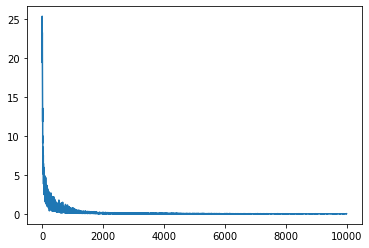

In [118]:
network = MLP_init(input_size=24, hidden_size=10, output_size=2)
#X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.4, stratify = label)
data1 = data[label==1]
data0 = data[label==0]
X_train = np.vstack((data1[:160],data0[:120]))
X_test = np.vstack((data1[160:],data0[120:]))
y_train = [1 for x in range(160)]
y_train.extend([0 for x in range(120)])
y_train = np.array(y_train)
y_test = [1 for x in range(90)]
y_test.extend([0 for x in range(30)])
y_test = np.array(y_test)

num_of_seed = np.random.randint(0, 100)
for l in [X_train, y_train]:
    np.random.seed(num_of_seed)
    np.random.shuffle(l)
num_of_seed = np.random.randint(0, 100)
for l in [X_test, y_test]:
    np.random.seed(num_of_seed)
    np.random.shuffle(l)


iters_num = 10000
learning_rate = 0.02
batch_size = 90
train_size = X_train.shape[0]
train_loss_list = []
train_acc_list = []
test_acc_list = []

for x in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)#変更点
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    grad = network.gradient(X_batch, y_batch)
    for key in ['W1', 'b1', 'W2', 'b2']:
            network.params[key] -= learning_rate * grad[key]
    train_loss_list.append(network.loss(X_batch, y_batch))
    if x % 1000 == 0:
        train_acc = network.accuracy(X_train, y_train)
        train_acc_list.append(train_acc)
        print(train_acc)
plt.plot(train_loss_list)
test_acc = network.accuracy(X_test, y_test)
print(test_acc)
y_pred = np.argmax(network.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [122]:
mean_list = np.mean(data, axis = 0)

array([[-0.12504259,  0.31077414,  0.37275154, ...,  0.51169293,
        -0.4843221 , -0.42008403],
       [-2.3300947 , -1.28977939,  0.37275154, ...,  0.51169293,
        -0.4843221 , -0.42008403],
       [ 0.62790203,  0.31077414,  0.34223253, ..., -1.95429709,
        -0.4843221 ,  2.38047614],
       ...,
       [-2.0611859 ,  0.31077414,  0.37275154, ...,  0.51169293,
        -0.4843221 , -0.42008403],
       [-1.79227711, -0.75626154,  0.38801104, ...,  0.51169293,
        -0.4843221 , -0.42008403],
       [ 0.412775  ,  0.31077414,  0.38801104, ...,  0.51169293,
        -0.4843221 , -0.42008403]])